In [ ]:
#@title Copyright (c) 2021 ZKM | Karlsruhe. BSD Simplified License. { display-mode: "form" }
"""
Simplified BSD License

Copyright (c) 2021 ZKM | Karlsruhe

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, 
this list of conditions and the following disclaimer.
2. Redistributions in binary form must reproduce the above copyright notice, 
this list of conditions and the following disclaimer in the documentation 
and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED 
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE 
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR
ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; 
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON 
ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT 
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS 
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
"""

# Spoken Language Identification Demonstration

This python notebook was developed to be used in Google Colaboratory. It is a demonstration of our active research tackling the task of spoken language identification (LID) using Deep Learning. If you would like to know more about the training procedure please visit us on [GitHub](hhttps://github.com/zkmkarlsruhe/language-identification/).

With this demonstration we will show you how to use our trained model. In essence we will run the following steps:
- Download and load the SavedModel trained using the above repository
- Access your microphone and record a snippet of 5 seconds
- Process and finally classfiy the language of the recorded audio

Our trained model is far from being perfect and fair. Please take a look at the caveats reported in our respository.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/zkmkarlsruhe/language-identification/blob/main/demo/LID_demo.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/zkmkarlsruhe/language-identification/blob/main/demo/LID_demo.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
</table>


# Acknowledgement
We would like to thank the [Kulturstiftung des Bundes](https://www.kulturstiftung-des-bundes.de/en) (German Federal Cultural Foundation) for funding the project [The Intelligent Museum](intelligent.museum) for which this code has been developed.

# Installs & Imports
We begin this notebook by installing and importing the necessary libraries. Most notably, we need TensorFlow to infer the neural network and ffmpeg to access audio data from your microphone.

In [ ]:
!pip install -q -U pip==20.2
!pip install -q tensorflow
!pip install -q ffmpeg-python

import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from scipy.io.wavfile import read as wav_read
from scipy.io.wavfile import write as wav_write


# Download, Unzip and Load the SavedModel
Next, we will download and unzip the SavedModel stored in our cloud. Afterwards, we load the model.

__Note:__ SavedModels do not only contain weights but also code! You should be careful when running such models. We hereby promise that we have created the model from scratch and did not include any malicious code.

In [ ]:
!wget -q -O model "https://cloud.zkm.de/index.php/s/83LwnXT9xDsyxGf/download?path=%2F&files=AttRnn.zip"
!unzip -q -o model

In [ ]:
model = load_model("AttRnn")

The model we are using here was trained to detect noise and distinguish English, French, German and Spanish from one another. Below we define the function that interprets the result.

In [ ]:
def get_language(prediction):
  index = tf.math.argmax(prediction).numpy()
  options = {0: "Noise",
             1: "English",
             2: "French",
             3: "German",
             4: "Spanish"}
  return options[index]

# Using the Microphone in Google Colab
In this notebook we will access the microphone using JavaScript. 
This code snippet `Record Function Definition using JS` has been adapted from the following repositories:
- https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be
- https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/


In [ ]:
#@title Record Function Definition using JS { display-mode: "form" }
# all imports
from IPython.display import Javascript, HTML, Audio
from google.colab import output
from base64 import b64decode
from google.colab.output import eval_js
import io
import ffmpeg

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  data = output.eval_js('record(%d)' % (sec*1000))  
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  out, err = process.communicate(input=binary)
  
  riff_chunk_size = len(out) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = out[:4] + bytes(b) + out[8:]

  sr, audio = wav_read(io.BytesIO(riff))
  return sr, audio  # or webm ?

Let's see if we can actually record a 5 second long audio piece. 

__Note:__ Please make sure to grant the necessary permissions.

<IPython.core.display.Javascript object>

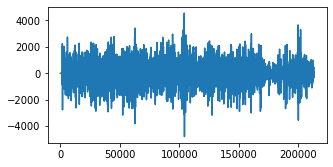

In [7]:
#@title Test, Safe and Plot
sampling_rate, audio = record(5)

wav_write ('audio.wav', sampling_rate, audio)

import matplotlib.pyplot as plt
plt.figure(figsize=(5,2.5))
plt.plot(audio)
plt.show()

# Define Preprocessing Functions

In order to feed the neural network the audio we have to prepare it the same way as it was during training. Using the python package `kapre` we were able to include most of the preprocessing (e.g. computing the fourier transformation) into the SavedModel. The few things we still have to do are listed below:
- Assure that the audio is sampled at 16kHz. In our setup we have noticed that the microphone was sampled at 48kHz. Therefore, we have to down-sample the audio piece. Try changing the value of `sample_rate` if this is different for you.
- During training the audio was mapped into the range of 0.0 to 1.0. We can do so, by dividing the sample by the largest absolute value.
- Next, we assure the length of the audio sample is padded or cut to exactly 5 seconds.
- In the last two steps we make sure to match the expected shape. First we add a channel for kapre's STFT algorithm and finally we add a dimension for the batch. Both added dimensions will be of size one.

In [18]:
import scipy.signal as sps

# input restrictions
length_s = 5
sample_rate = 48000
target_sample_rate = 16000
num_samples = length_s * target_sample_rate

def down_sample(audio, sampling_rate=48000, target_rate=16000):
  number_of_samples = round(len(audio) * float(target_rate) / sampling_rate)
  audio = sps.resample(audio, number_of_samples)
  return audio

def normalize(signal):
	maximum = max(abs(signal.max()), abs(signal.min()))
	if maximum == 0.0:
		print("normalize: omitting to divide by zero!!")
		return signal
	return signal / float(maximum)
 
def pad_or_cut(data, max_len):
  if len(data) == max_len:
    return data
  elif len(data) > max_len:
    return data[:max_len]
  else:
    to_add = max(max_len - len(data), 0)
    data = np.pad(data, (0, to_add), mode='constant', constant_values=0)
    return data

def pre_process(audio):
  audio = down_sample(audio, sample_rate,
                      target_sample_rate)     # input must be sampled at 16000kHz
  audio = normalize(audio)                    # input range is floating point from 0 to 1
  audio = pad_or_cut(audio, num_samples)      # input must be 80000
  audio = tf.expand_dims(audio, -1)           # add a channel for stft
  audio = tf.expand_dims(audio, 0)            # make it a batch
  return audio

# Record, Preprocess and Classify the Audio 
Now let's put everything together and see how good the model performs!

__Note:__ run the next block multiple times to classify new recordings.

In [19]:
sr, audio = record(5)
audio = pre_process(audio)
prediction = model.predict(audio)
language = get_language(prediction[0])
print(language)

<IPython.core.display.Javascript object>

(1, 80000, 1)
English
